In [221]:
import sys
from pathlib import Path

# Get the project root (assuming this notebook is inside /notebooks)
project_root = Path.cwd().parent

sys.path.append(str(project_root))

from src.extract import load_csv

df = load_csv("listings_cleaned.csv", folder="processed")

Loaded 17,730 rows from C:\Users\Ross\Desktop\Data Analytics Proj\AirbnbProject\data\processed\listings_cleaned.csv


In [200]:
missing_summary = (
    df.isnull()
      .sum()
      .reset_index()
      .rename(columns={'index': 'column', 0: 'missing_count'})
)

# Add percent of missing values
missing_summary['missing_percent'] = (missing_summary['missing_count'] / len(df)) * 100

# Add data type for context
missing_summary['dtype'] = df.dtypes.values

# Only show columns with any missing values, sorted highest first
missing_summary = missing_summary[missing_summary['missing_count'] > 0].sort_values(
    by='missing_percent', ascending=False
)

# Display the result
missing_summary.head(20) 

,column,missing_count,missing_percent,dtype
35,bathrooms,17730,100.000000,float64
40,price,17730,100.000000,float64
38,beds,17730,100.000000,float64
29,neighbourhood_group_cleansed,17730,100.000000,float64
62,estimated_revenue_l365d,17730,100.000000,float64
49,calendar_updated,17730,100.000000,float64
21,host_neighbourhood,13096,73.863508,object
27,neighbourhood,9617,54.241399,object
7,neighborhood_overview,9617,54.241399,object
14,host_about,7352,41.466441,object


In [201]:
def drop_missing_columns(df, threshold=0.4):
    """
    Drops columns from a DataFrame where the percentage of missing values
    exceeds the given threshold (default 40%).

    Parameters:
        df (pd.DataFrame): The input DataFrame.
        threshold (float): The maximum allowed fraction of missing values.
                           Columns with a higher fraction are dropped.

    Returns:
        pd.DataFrame: The cleaned DataFrame with high-missing columns removed.
    """
    # Calculate the fraction of missing values for each column
    missing_fraction = df.isnull().mean()

    # Identify columns where the fraction of missing data > threshold
    cols_to_drop = missing_fraction[missing_fraction > threshold].index

    # Print for visibility
    print(f"Dropping {len(cols_to_drop)} columns (>{threshold*100:.0f}% missing):")
    print(list(cols_to_drop))

    # Drop them and return the updated DataFrame
    df = df.drop(columns=cols_to_drop)

    return df
df = drop_missing_columns(df)

Dropping 10 columns (>40% missing):
['neighborhood_overview', 'host_about', 'host_neighbourhood', 'neighbourhood', 'neighbourhood_group_cleansed', 'bathrooms', 'beds', 'price', 'calendar_updated', 'estimated_revenue_l365d']


In [202]:
columns_to_keep = [
    # Listing details
    'property_type', 'room_type', 'accommodates', 'bathrooms', 'bathrooms_text',
    'bedrooms', 'beds', 'minimum_nights', 'maximum_nights',
    'availability_30', 'availability_60', 'availability_90', 'availability_365',

    # Pricing & reviews
    'price', 'security_deposit', 'cleaning_fee', 'extra_people',
    'number_of_reviews', 'reviews_per_month',
    'review_scores_rating', 'review_scores_cleanliness', 
    'review_scores_communication', 'review_scores_location', 'review_scores_value',

    # Host information
    'host_since', 'host_response_time', 'host_is_superhost',
    'host_listings_count', 'host_identity_verified',

    # Host behavior
    'host_response_rate', 'host_acceptance_rate', 'host_total_listings_count',
    
    # Location
    'neighbourhood_cleansed', 'latitude', 'longitude',

    # Activity dates
    'last_review', 'first_review'
]
columns_to_keep = [col for col in keep_cols if col in df.columns]
df = df[columns_to_keep]

print(f"✅ Retained {len(columns_to_keep)} columns:")
for col in columns_to_keep:
    print(f" - {col}")


✅ Retained 31 columns:
 - property_type
 - room_type
 - accommodates
 - bathrooms_text
 - bedrooms
 - minimum_nights
 - maximum_nights
 - availability_30
 - availability_60
 - availability_90
 - availability_365
 - number_of_reviews
 - reviews_per_month
 - review_scores_rating
 - review_scores_cleanliness
 - review_scores_communication
 - review_scores_location
 - review_scores_value
 - host_since
 - host_response_time
 - host_is_superhost
 - host_listings_count
 - host_identity_verified
 - host_response_rate
 - host_acceptance_rate
 - host_total_listings_count
 - neighbourhood_cleansed
 - latitude
 - longitude
 - last_review
 - first_review


In [203]:
df['bathrooms_text'].value_counts()

bathrooms_text
1 bath               8358
2 baths              3522
1 shared bath        1265
1 private bath       1149
3 baths               730
1.5 baths             687
2.5 baths             642
2 shared baths        282
3.5 baths             227
1.5 shared baths      215
4 baths               190
4.5 baths              75
5 baths                66
2.5 shared baths       63
0 baths                54
0 shared baths         38
3 shared baths         33
Shared half-bath       28
Private half-bath      22
5.5 baths              20
Half-bath              15
6 baths                13
7 baths                 5
4 shared baths          5
6.5 baths               4
3.5 shared baths        3
8 baths                 2
12 baths                2
7.5 baths               1
11 baths                1
7 shared baths          1
21 shared baths         1
Name: count, dtype: int64

In [204]:
for col in df.select_dtypes(include='object').columns:
    df[col] = (
        df[col]
        .str.lower()          # make all text lowercase
        .str.strip()          # remove leading/trailing spaces
        .replace('', np.nan)  # convert empty strings to NaN
    )

In [205]:
# 1. Create a boolean column for shared bathrooms
df['shared_bath'] = df['bathrooms_text'].str.contains('shared', case=False, na=False)

# 2. Handle 'half-bath' variations (replace text with 0.5 for numeric conversion)
df['bathrooms_text'] = df['bathrooms_text'].str.replace('half-bath', '0.5', case=False, regex=True)

# 3. Extract the first numeric value from the string (e.g., "2.5", "1", "0.5")
df['bathrooms'] = (
    df['bathrooms_text']
    .str.extract(r'(\d*\.?\d+)')[0]  # get first number
    .astype(float)                   # convert to float
)
for col in ['host_response_rate', 'host_acceptance_rate']:
    df[col] = (
        df[col]
        .str.replace('%', '', regex=False)  # remove percent sign
        .astype(float) / 100                 # convert to decimal
    )

# 4. Fill missing numeric values (optional — only if you want to avoid NaNs)
df['bathrooms'].fillna(0, inplace=True)

# 5. Drop the original text column
df.drop(columns=['bathrooms_text'], inplace=True)

# 6. Verify results
print(df[['bathrooms', 'shared_bath']].head(10))

   bathrooms  shared_bath
0        1.0         True
1        1.0        False
2        1.0        False
3        1.0        False
4        2.5         True
5        1.0        False
6        1.0        False
7        1.0        False
8        1.0        False
9        1.0        False


C:\Users\Ross\AppData\Local\Temp\ipykernel_172\2374855653.py:21: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df['bathrooms'].fillna(0, inplace=True)


In [206]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17730 entries, 0 to 17729
Data columns (total 32 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   property_type                17730 non-null  object 
 1   room_type                    17730 non-null  object 
 2   accommodates                 17730 non-null  int64  
 3   bedrooms                     14059 non-null  float64
 4   minimum_nights               17730 non-null  int64  
 5   maximum_nights               17730 non-null  int64  
 6   availability_30              17730 non-null  int64  
 7   availability_60              17730 non-null  int64  
 8   availability_90              17730 non-null  int64  
 9   availability_365             17730 non-null  int64  
 10  number_of_reviews            17730 non-null  int64  
 11  reviews_per_month            15020 non-null  float64
 12  review_scores_rating         15020 non-null  float64
 13  review_scores_cl

In [207]:
pd.set_option('display.max_columns', None)
tempdf = df
tempdf.head()

,property_type,room_type,accommodates,bedrooms,minimum_nights,maximum_nights,availability_30,availability_60,availability_90,availability_365,number_of_reviews,reviews_per_month,review_scores_rating,review_scores_cleanliness,review_scores_communication,review_scores_location,review_scores_value,host_since,host_response_time,host_is_superhost,host_listings_count,host_identity_verified,host_response_rate,host_acceptance_rate,host_total_listings_count,neighbourhood_cleansed,latitude,longitude,last_review,first_review,shared_bath,bathrooms
0,private room in rental unit,private room,1,NaN,90,180,29,59,89,364,193,1.01,4.59,4.30,4.76,4.82,4.71,2009-09-23,a few days or more,f,1.0,f,0.0,NaN,1.0,sydney,-33.86767,151.22497,2020-03-13,2009-12-05,True,1.0
1,private room in condo,private room,2,NaN,1,90,14,42,63,295,632,3.83,4.55,4.52,4.75,4.76,4.57,2009-12-03,within an hour,f,1.0,t,1.0,1.00,2.0,sydney,-33.87964,151.21680,2025-09-01,2012-02-23,False,1.0
2,entire loft,entire home/apt,2,1.0,2,180,0,0,0,0,85,0.47,4.89,4.85,4.96,4.94,4.80,2010-04-22,within a few hours,t,1.0,t,1.0,0.82,1.0,sydney,-33.87888,151.21439,2025-08-31,2010-10-20,False,1.0
3,entire guest suite,entire home/apt,4,1.0,2,90,10,16,23,138,448,2.50,4.64,4.35,4.92,4.76,4.73,2010-11-06,within a day,t,1.0,t,1.0,0.94,3.0,mosman,-33.81748,151.23484,2025-08-31,2010-12-29,False,1.0
4,private room in home,private room,4,2.0,1,30,0,2,15,265,120,0.69,4.97,4.99,4.99,4.85,4.93,2011-01-03,within an hour,t,1.0,t,1.0,0.90,3.0,hornsby,-33.72966,151.05226,2025-06-08,2011-06-21,True,2.5


In [208]:
date_cols = ['host_since', 'last_review', 'first_review', ]
numeric_cols = ['accommodates', 'minimum_nights', 'maximum_nights', 'availability_30', 'availability_60', 'availability_90', 'availability_365', 'number_of_reviews', 'reviews_per_month', 'review_scores_rating', 
                'review_scores_communication', 'review_scores_location', 'review_scores_location', 'review_scores_value', 'host_listings_count', 'host_total_listings_count', 
                'latitude', 'longitude', 'bathrooms', 'review_scores_cleanliness', 'bedrooms', 'host_response_rate', 'host_acceptance_rate']
bool_cols = ['host_is_superhost', 'host_identity_verified', 'shared_bath']
str_cols = ['host_response_time', 'neighbourhood_cleansed', 'property_type', 'room_type']
classified_cols = date_cols + numeric_cols + bool_cols + str_cols

# Find which of those actually exist in df
cols_to_drop = [col for col in classified_cols if col in df.columns]

# Print what’s being removed
print(f"Dropping {len(cols_to_drop)} categorized columns:")
for col in cols_to_drop:
    print(f" - {col}")

# Drop and create tempdf
tempdf = df.drop(columns=cols_to_drop, errors='ignore')


Dropping 33 categorized columns:
 - host_since
 - last_review
 - first_review
 - accommodates
 - minimum_nights
 - maximum_nights
 - availability_30
 - availability_60
 - availability_90
 - availability_365
 - number_of_reviews
 - reviews_per_month
 - review_scores_rating
 - review_scores_communication
 - review_scores_location
 - review_scores_location
 - review_scores_value
 - host_listings_count
 - host_total_listings_count
 - latitude
 - longitude
 - bathrooms
 - review_scores_cleanliness
 - bedrooms
 - host_response_rate
 - host_acceptance_rate
 - host_is_superhost
 - host_identity_verified
 - shared_bath
 - host_response_time
 - neighbourhood_cleansed
 - property_type
 - room_type


In [209]:
df[date_cols] = df[date_cols].apply(pd.to_datetime, errors='coerce')

for col in numeric_cols:
    if col in df.columns:
        df[col] = pd.to_numeric(df[col], errors='coerce')

for col in bool_cols:
    df[col] = (
        df[col]
        .astype(str)
        .str.strip()
        .str.lower()
        .map({'t': True, 'f': False, 'true': True, 'false': False, 'yes': True, 'no': False})
    )

for col in str_cols:
    if col in df.columns:
        df[col] = df[col].astype('string')



In [210]:
print("Dates:", len(date_cols))
print("Numeric:", len(numeric_cols))
print("Booleans:", len(bool_cols))
print("Strings:", len(str_cols))

Dates: 3
Numeric: 23
Booleans: 3
Strings: 4


In [211]:

df.dtypes

property_type                  string[python]
room_type                      string[python]
accommodates                            int64
bedrooms                              float64
minimum_nights                          int64
maximum_nights                          int64
availability_30                         int64
availability_60                         int64
availability_90                         int64
availability_365                        int64
number_of_reviews                       int64
reviews_per_month                     float64
review_scores_rating                  float64
review_scores_cleanliness             float64
review_scores_communication           float64
review_scores_location                float64
review_scores_value                   float64
host_since                     datetime64[ns]
host_response_time             string[python]
host_is_superhost                      object
host_listings_count                   float64
host_identity_verified            

In [212]:
df['host_is_superhost'] = (
    df['host_is_superhost']
    .astype(str)
    .str.strip()
    .str.lower()
    .map({'t': True, 'f': False, 'true': True, 'false': False, 'yes': True, 'no': False})
)

df['host_identity_verified'] = (
    df['host_identity_verified']
    .astype(str)
    .str.strip()
    .str.lower()
    .map({'t': True, 'f': False, 'true': True, 'false': False, 'verified': True, 'unverified': False})
)

In [213]:
df.dtypes

property_type                  string[python]
room_type                      string[python]
accommodates                            int64
bedrooms                              float64
minimum_nights                          int64
maximum_nights                          int64
availability_30                         int64
availability_60                         int64
availability_90                         int64
availability_365                        int64
number_of_reviews                       int64
reviews_per_month                     float64
review_scores_rating                  float64
review_scores_cleanliness             float64
review_scores_communication           float64
review_scores_location                float64
review_scores_value                   float64
host_since                     datetime64[ns]
host_response_time             string[python]
host_is_superhost                      object
host_listings_count                   float64
host_identity_verified            

In [214]:
df['host_is_superhost'] = df['host_is_superhost'].astype('boolean')
df['host_identity_verified'] = df['host_identity_verified'].astype('boolean')
df.dtypes

property_type                  string[python]
room_type                      string[python]
accommodates                            int64
bedrooms                              float64
minimum_nights                          int64
maximum_nights                          int64
availability_30                         int64
availability_60                         int64
availability_90                         int64
availability_365                        int64
number_of_reviews                       int64
reviews_per_month                     float64
review_scores_rating                  float64
review_scores_cleanliness             float64
review_scores_communication           float64
review_scores_location                float64
review_scores_value                   float64
host_since                     datetime64[ns]
host_response_time             string[python]
host_is_superhost                     boolean
host_listings_count                   float64
host_identity_verified            

In [215]:
print("Dates:", len(date_cols))
print("Numeric:", len(numeric_cols))
print("Booleans:", len(bool_cols))
print("Strings:", len(str_cols))

Dates: 3
Numeric: 23
Booleans: 3
Strings: 4


In [216]:
def summarize_outliers(df, iqr_multiplier=1.5):
    """
    Summarizes and visualizes potential outliers for all numeric columns in a DataFrame.
    Uses the IQR rule: values outside [Q1 - 1.5*IQR, Q3 + 1.5*IQR] are flagged as outliers.
    """
    numeric_cols = df.select_dtypes(include=['float', 'int']).columns
    summary = []

    for col in numeric_cols:
        Q1 = df[col].quantile(0.25)
        Q3 = df[col].quantile(0.75)
        IQR = Q3 - Q1

        lower_bound = Q1 - iqr_multiplier * IQR
        upper_bound = Q3 + iqr_multiplier * IQR

        outliers = df[(df[col] < lower_bound) | (df[col] > upper_bound)][col]
        summary.append({
            'Column': col,
            'Outliers': len(outliers),
            'Total': df[col].notna().sum(),
            'Percent': round((len(outliers) / df[col].notna().sum()) * 100, 2)
        })

        # Quick visualization
        plt.figure(figsize=(6, 2))
        df.boxplot(column=col)
        plt.title(f'{col} — potential outliers')
        plt.show()

    summary_df = pd.DataFrame(summary).sort_values(by='Percent', ascending=False)
    return summary_df

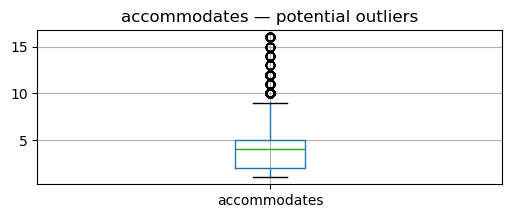

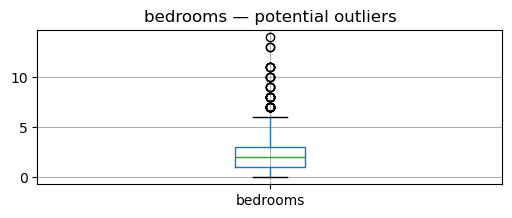

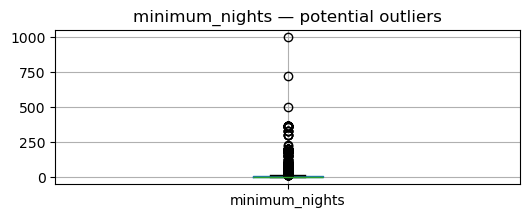

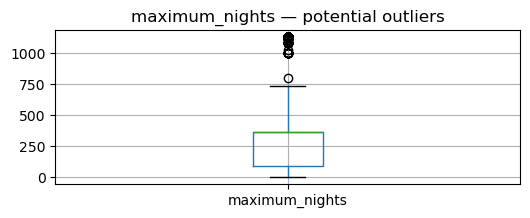

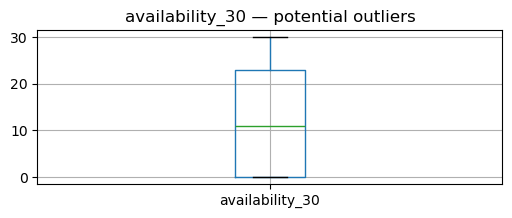

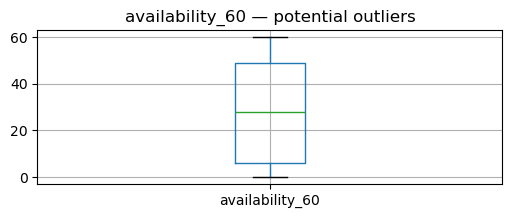

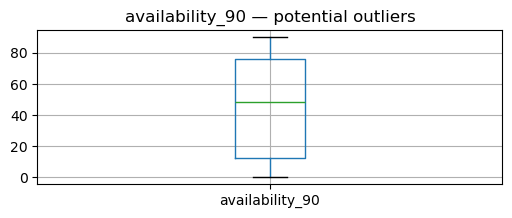

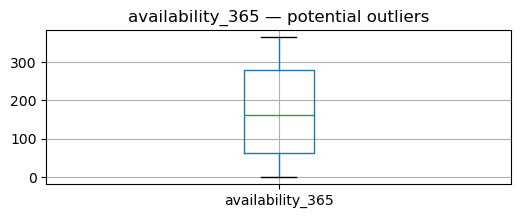

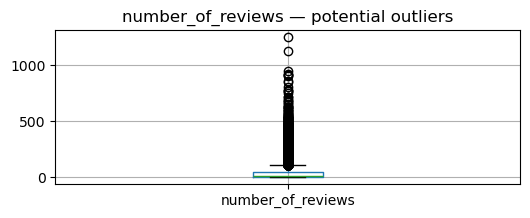

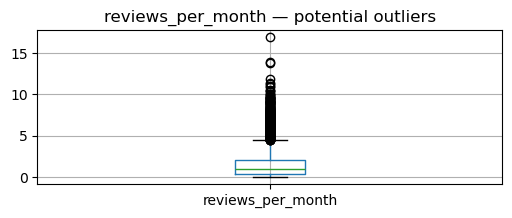

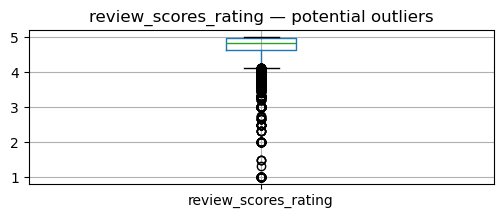

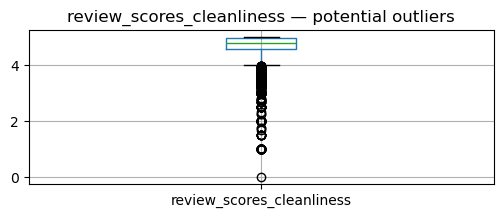

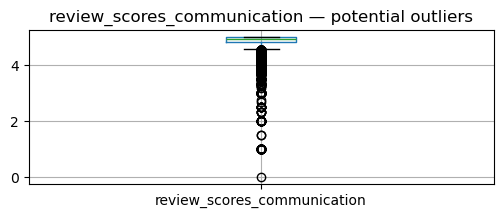

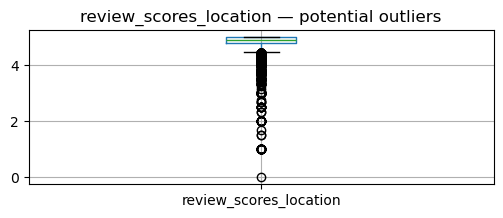

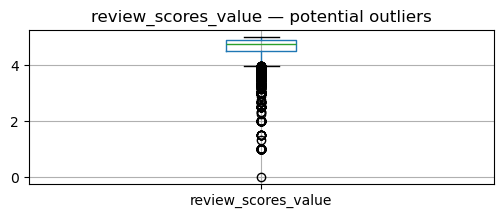

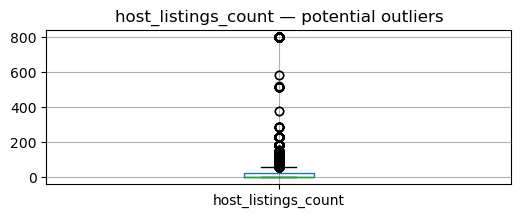

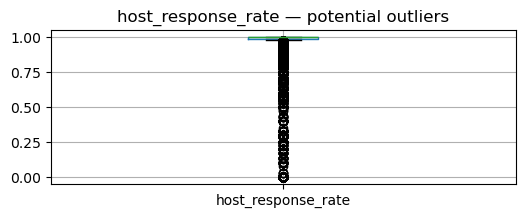

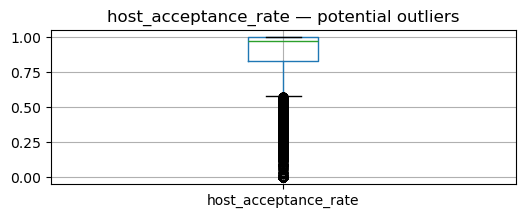

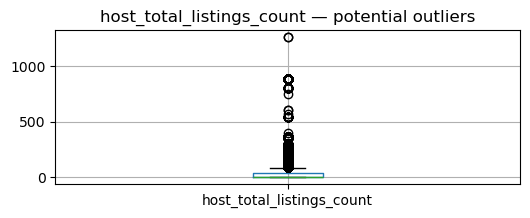

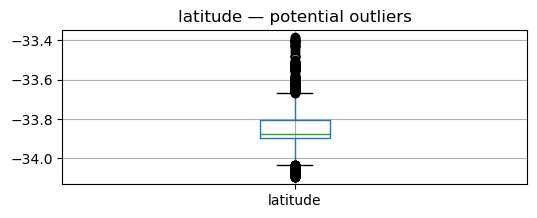

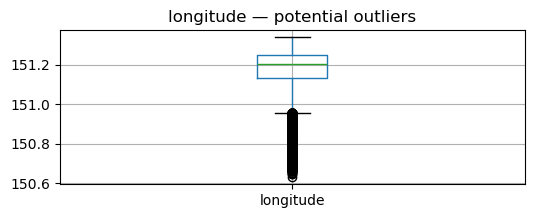

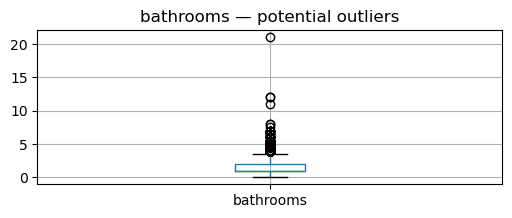

,Column,Outliers,Total,Percent
3,maximum_nights,3869,17730,21.82
16,host_response_rate,2701,14388,18.77
2,minimum_nights,3296,17730,18.59
18,host_total_listings_count,2631,17728,14.84
17,host_acceptance_rate,2087,15421,13.53
15,host_listings_count,2207,17728,12.45
8,number_of_reviews,1751,17730,9.88
12,review_scores_communication,1347,15019,8.97
19,latitude,1378,17730,7.77
13,review_scores_location,985,15018,6.56


In [219]:
import matplotlib.pyplot as plt
outlier_summary = summarize_outliers(df)
outlier_summary.head(10)